# Flatiron Health mCRC: Relaxed trials with GBM crude + dose correction

***OBJECTIVE:*** **Reproduce FIRE trial while ensuring patients receiving chemotherapy are getting an  appropriate first dose. Inclusion criteria for this trials will be pragmatically relaxed to allow for entry of our real-world patients, many of which would not meet inclusion criteria in randomized controlled trials. Patients included in our trials will next be risk stratified using the gradient boosted model with crude imputation into 1 of 3 risk groups: high (top tertile), medium (middle tertile), and low (bottom tertile). Inverse-probability treatment weighted survival analysis will then be performed across these risk groups to get real-world estimates of survival while adjusting for measured confounders.** 

***OUTLINE:***
1. **Preprocessing**


2. **In-silico trials:**
* FIRE-3 

## Part 1: Preprocessing

### 1.1 Import packages and create necessary functions

In [1]:
import numpy as np
import pandas as pd

from scipy import stats

from sksurv.nonparametric import kaplan_meier_estimator
from survive import KaplanMeier, SurvivalData

from lifelines import KaplanMeierFitter
from lifelines.plotting import add_at_risk_counts
from lifelines.utils import median_survival_times

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer 
from sklearn.linear_model import LogisticRegression

from matplotlib.lines import Line2D   

In [2]:
# Function that returns number of rows and count of unique PatientIDs for a dataframe. 
def row_ID(dataframe):
    row = dataframe.shape[0]
    ID = dataframe['PatientID'].nunique()
    return row, ID

In [3]:
cutoff = pd.read_csv('risk_cutoff_colorectal.csv', index_col = 0)

## Part 2: In silico trials 

### FIRE-3: FOLFIRI plus cetuximab vs. FOLFIRI plus bevacizumab in KRAS wild-type 

**INCLUSION**
* Untreated metastatic colorectal cancer
* First-line recepit of FOLFIRI/FOLFOX plus cetuximab or FOLFIRI/FOLFOX plus bevacizumab
* KRAS wild-type 

#### FOLFIRI plus Cetuximab

In [4]:
df_full = pd.read_csv('df_risk_crude.csv', index_col = 'PatientID', dtype = {'death_status': bool})
df_full.index.nunique()

34315

In [5]:
line_therapy = pd.read_csv('LineOfTherapy.csv')

In [6]:
line_therapy_fl = (
    line_therapy[line_therapy['PatientID'].isin(df_full.index)]
    .query('LineNumber == 1')
    .query('IsMaintenanceTherapy == False'))

In [7]:
line_therapy_fl[line_therapy_fl['LineName'].str.contains('FOLFOX|Cetuximab')].LineName.value_counts().head(10)

FOLFOX,Bevacizumab            6338
FOLFOX                        4140
FOLFOX,Bevacizumab-Awwb       1356
FOLFOX,Bevacizumab-Bvzr        462
FOLFOX,Panitumumab             456
FOLFIRI,Cetuximab              364
FOLFOXIRI                      253
FOLFOX,Cetuximab               245
FOLFOXIRI,Bevacizumab          228
FOLFOXIRI,Bevacizumab-Awwb     140
Name: LineName, dtype: int64

In [8]:
line_therapy_fl[line_therapy_fl['LineName'].str.contains('FOLFIRI|Cetuximab')].LineName.value_counts().head(10)

FOLFIRI,Bevacizumab         2240
FOLFIRI                      914
FOLFIRI,Bevacizumab-Awwb     557
FOLFIRI,Cetuximab            364
FOLFIRI,Panitumumab          261
FOLFOX,Cetuximab             245
FOLFIRI,Bevacizumab-Bvzr     165
Irinotecan,Cetuximab          90
Cetuximab                     70
FOLFIRI,Ziv-Aflibercept       56
Name: LineName, dtype: int64

In [9]:
fxi_cet = (
    line_therapy_fl
    .query('LineName == "FOLFIRI,Cetuximab" or LineName == "FOLFOX,Cetuximab"')
    [['PatientID', 'StartDate']]
)

In [10]:
fxi_cet.loc[:,'fxi_cet'] = 1

In [11]:
row_ID(fxi_cet)

(609, 568)

In [12]:
fxi_cet['StartDate'] = pd.to_datetime(fxi_cet['StartDate'])

In [13]:
fxi_cet = (
    fxi_cet
    .sort_values(['PatientID', 'StartDate'], ascending = [True, True])
    .drop_duplicates(subset = 'PatientID', keep = 'first')
)

In [14]:
row_ID(fxi_cet)

(568, 568)

#### FOLFIRI plus Bevacizumab

In [15]:
line_therapy_fl[line_therapy_fl['LineName'].str.contains('FOLFIRI|Bevacizumab')].LineName.value_counts().head(10)

FOLFOX,Bevacizumab                     6338
FOLFIRI,Bevacizumab                    2240
FOLFOX,Bevacizumab-Awwb                1356
FOLFIRI                                 914
CAPEOX,Bevacizumab                      764
FOLFIRI,Bevacizumab-Awwb                557
FOLFOX,Bevacizumab-Bvzr                 462
Fluorouracil,Leucovorin,Bevacizumab     423
Capecitabine,Bevacizumab                405
FOLFIRI,Cetuximab                       364
Name: LineName, dtype: int64

In [16]:
line_therapy_fl[line_therapy_fl['LineName'].str.contains('FOLFOX|Bevacizumab')].LineName.value_counts().head(10)

FOLFOX,Bevacizumab                     6338
FOLFOX                                 4140
FOLFIRI,Bevacizumab                    2240
FOLFOX,Bevacizumab-Awwb                1356
CAPEOX,Bevacizumab                      764
FOLFIRI,Bevacizumab-Awwb                557
FOLFOX,Bevacizumab-Bvzr                 462
FOLFOX,Panitumumab                      456
Fluorouracil,Leucovorin,Bevacizumab     423
Capecitabine,Bevacizumab                405
Name: LineName, dtype: int64

In [17]:
fxi_bev_comb = [
    'FOLFIRI,Bevacizumab',
    'FOLFIRI,Bevacizumab-Awwb',
    'FOLFIRI,Bevacizumab-Bvzr',
    'FOLFOX,Bevacizumab',
    'FOLFOX,Bevacizumab-Awwb',
    'FOLFOX,Bevacizumab-Bvzr'
]

fxi_bev = (
    line_therapy_fl
    .query('LineName == @fxi_bev_comb')
    [['PatientID', 'StartDate']]
)

In [18]:
fxi_bev.loc[:,'fxi_cet'] = 0

In [19]:
row_ID(fxi_bev)

(11118, 10785)

In [20]:
fxi_bev['StartDate'] = pd.to_datetime(fxi_bev['StartDate'])

In [21]:
fxi_bev = (
    fxi_bev
    .sort_values(['PatientID', 'StartDate'], ascending = [True, True])
    .drop_duplicates(subset = 'PatientID', keep = 'first')
)

In [22]:
row_ID(fxi_bev)

(10785, 10785)

In [23]:
fire = pd.concat([fxi_cet, fxi_bev])

In [24]:
row_ID(fire)

(11353, 11353)

In [25]:
fire = pd.merge(fire, df_full, on = 'PatientID', how = 'left')

In [26]:
row_ID(fire)

(11353, 11353)

#### Chemotherapy dosing

##### Oxaliplatin dosing

In [27]:
med_order = pd.read_csv('MedicationOrder.csv', low_memory = False)

In [28]:
med_order['ExpectedStartDate'] = np.where(med_order['ExpectedStartDate'].isna(), 
                                          med_order['OrderedDate'], 
                                          med_order['ExpectedStartDate'])

In [29]:
med_order.loc[:, 'ExpectedStartDate'] = pd.to_datetime(med_order['ExpectedStartDate'], errors = 'coerce')

In [30]:
fire.loc[:, 'StartDate'] = pd.to_datetime(fire['StartDate'])

In [31]:
med_order_ox = (
    med_order[med_order['PatientID'].isin(fire.PatientID)]
    .query('CommonDrugName == "oxaliplatin"')
)

In [32]:
med_order_ox.shape

(124824, 19)

In [33]:
med_order_ox = pd.merge(med_order_ox, 
                        fire[['PatientID', 'StartDate']], 
                        on = 'PatientID', 
                        how = 'left')

In [34]:
med_order_ox.shape

(124824, 20)

In [35]:
med_order_ox.loc[:, 'date_diff'] = (med_order_ox['ExpectedStartDate'] - med_order_ox['StartDate']).dt.days.abs()

In [36]:
med_order_ox = med_order_ox.query('date_diff <= 14')

In [37]:
ox_index = med_order_ox.groupby('PatientID')['date_diff'].idxmin()

In [38]:
ox_dose = med_order_ox.loc[ox_index].query('RelativeOrderedUnits == "mg/m2"')[['PatientID', 'RelativeOrderedAmount']]

In [39]:
ox_dose = ox_dose.rename(columns = {'RelativeOrderedAmount': 'ox_dose_mgm2'})

In [40]:
ox_IDs = ox_dose.query('ox_dose_mgm2 >= 85').PatientID

##### Irinotecan dosing

In [41]:
med_order_iri = (
    med_order[med_order['PatientID'].isin(fire.PatientID)]
    .query('CommonDrugName == "irinotecan"')
)

In [42]:
med_order_iri.shape

(123981, 19)

In [43]:
med_order_iri = pd.merge(med_order_iri, 
                         fire[['PatientID', 'StartDate']], 
                         on = 'PatientID', 
                         how = 'left')

In [44]:
med_order_iri.shape

(123981, 20)

In [45]:
med_order_iri.loc[:, 'date_diff'] = (med_order_iri['ExpectedStartDate'] - med_order_iri['StartDate']).dt.days.abs()

In [46]:
med_order_iri = med_order_iri.query('date_diff <= 14')

In [47]:
iri_index = med_order_iri.groupby('PatientID')['date_diff'].idxmin()

In [48]:
iri_dose = med_order_iri.loc[iri_index].query('RelativeOrderedUnits == "mg/m2"')[['PatientID', 'RelativeOrderedAmount']]

In [49]:
iri_dose = iri_dose.rename(columns = {'RelativeOrderedAmount': 'iri_dose_mgm2'})

In [50]:
iri_IDs = iri_dose.query('iri_dose_mgm2 >= 125').PatientID

In [51]:
fire = fire[fire['PatientID'].isin(pd.concat([ox_IDs, iri_IDs]))]

In [52]:
row_ID(fire)

(9359, 9359)

#### KRAS wild type 

In [53]:
biomarkers = pd.read_csv('Enhanced_MetCRCBiomarkers.csv')

In [54]:
biomarkers = biomarkers[biomarkers['PatientID'].isin(fire['PatientID'])]

In [55]:
row_ID(biomarkers)

(38832, 8702)

In [56]:
biomarkers = pd.merge(biomarkers, fire[['PatientID', 'StartDate']], on = 'PatientID', how = 'left')

In [57]:
row_ID(biomarkers)

(38832, 8702)

In [58]:
biomarkers['ResultDate'] = pd.to_datetime(biomarkers['ResultDate'])

In [59]:
biomarkers['SpecimenReceivedDate'] = pd.to_datetime(biomarkers['SpecimenReceivedDate'])

In [60]:
biomarkers.loc[:, 'result_date'] = (
    np.where(biomarkers['ResultDate'].isna(), biomarkers['SpecimenReceivedDate'], biomarkers['ResultDate'])
)

In [61]:
biomarkers.loc[:, 'date_diff'] = (biomarkers['result_date'] - biomarkers['StartDate']).dt.days

In [62]:
kras = (
    biomarkers
    .query('BiomarkerName == "KRAS"')
    .query('date_diff <=30')
    .query('BiomarkerStatus == "Mutation negative"')
    [['PatientID', 'BiomarkerStatus']]
    .rename(columns = {'BiomarkerStatus': 'kras_n'})
    .drop_duplicates(subset = 'PatientID', keep = 'first')
)

In [63]:
row_ID(kras)

(3058, 3058)

In [64]:
fire = pd.merge(fire, kras, on  = 'PatientID', how = 'left')

In [65]:
row_ID(fire)

(9359, 9359)

#### Time from treatment to death or censor 

In [66]:
mortality_tr = pd.read_csv('mortality_cleaned_tr.csv')

In [67]:
mortality_te = pd.read_csv('mortality_cleaned_te.csv')

In [68]:
mortality_tr = mortality_tr[['PatientID', 'death_date', 'last_activity']]

In [69]:
mortality_te = mortality_te[['PatientID', 'death_date', 'last_activity']]

In [70]:
mortality = pd.concat([mortality_tr, mortality_te], ignore_index = True)
print(len(mortality), mortality.PatientID.is_unique)

34315 True


In [71]:
mortality.loc[:, 'last_activity'] = pd.to_datetime(mortality['last_activity'])

In [72]:
mortality.loc[:, 'death_date'] = pd.to_datetime(mortality['death_date'])

In [73]:
len(mortality)

34315

In [74]:
fire = pd.merge(fire, mortality, on = 'PatientID', how = 'left')

In [75]:
len(fire)

9359

In [76]:
conditions = [
    (fire['death_status'] == 1),
    (fire['death_status'] == 0)]

choices = [
    (fire['death_date'] - fire['StartDate']).dt.days,
    (fire['last_activity'] - fire['StartDate']).dt.days]

fire.loc[:, 'timerisk_treatment'] = np.select(conditions, choices)

In [77]:
fire = fire.query('timerisk_treatment >= 0')

In [78]:
row_ID(fire)

(9352, 9352)

#### Patient count 

In [79]:
fire = (
    fire
    .query('kras_n == "Mutation negative"')
)

In [80]:
low_cutoff_fire = cutoff.loc['fire3'].low

In [81]:
high_cutoff_fire = cutoff.loc['fire3'].high

In [82]:
print('FOLFIRI + Cetuximab total:',  fire.query('fxi_cet == 1').shape[0])
print('High risk:', fire.query('fxi_cet == 1').query('risk_score >= @high_cutoff_fire').shape[0])
print('Med risk:', fire.query('fxi_cet == 1').query('risk_score < @high_cutoff_fire and risk_score > @low_cutoff_fire').shape[0])
print('Low risk:', fire.query('fxi_cet == 1').query('risk_score <= @low_cutoff_fire').shape[0])

FOLFIRI + Cetuximab total: 432
High risk: 120
Med risk: 159
Low risk: 153


In [83]:
print('FOLFIRI + Bevacizumab:',  fire.query('fxi_cet == 0').shape[0])
print('High risk:', fire.query('fxi_cet == 0').query('risk_score >= @high_cutoff_fire').shape[0])
print('Med risk:', fire.query('fxi_cet == 0').query('risk_score < @high_cutoff_fire and risk_score > @low_cutoff_fire').shape[0])
print('Low risk:', fire.query('fxi_cet == 0').query('risk_score <= @low_cutoff_fire').shape[0])

FOLFIRI + Bevacizumab: 2624
High risk: 894
Med risk: 880
Low risk: 850


#### Survival curves with covariate balancing 

In [84]:
fire = fire.set_index('PatientID')

In [85]:
fire['met_cat'] = pd.cut(fire['met_year'],
                         bins = [2010, 2015, float('inf')],
                         labels = ['11-15', '16-22'])

In [86]:
conditions = [
    ((fire['ecog_diagnosis'] == "1.0") | (fire['ecog_diagnosis'] == "0.0")),  
    ((fire['ecog_diagnosis'] == "2.0") | (fire['ecog_diagnosis'] == "3.0"))
]

choices = ['lt_2', 'gte_2']

fire['ecog_2'] = np.select(conditions, choices, default = 'unknown')

In [87]:
fire_iptw = fire.filter(items = ['death_status',
                                 'timerisk_treatment',
                                 'fxi_cet',
                                 'age',
                                 'gender',
                                 'race',
                                 'p_type',
                                 'crc_site',
                                 'met_cat',
                                 'delta_met_diagnosis',
                                 'commercial',
                                 'medicare',
                                 'medicaid',
                                 'ecog_2', 
                                 'ses',
                                 'albumin_diag',
                                 'weight_pct_change',
                                 'risk_score'])

In [88]:
fire_iptw.dtypes

death_status               bool
timerisk_treatment      float64
fxi_cet                   int64
age                       int64
gender                   object
race                     object
p_type                   object
crc_site                 object
met_cat                category
delta_met_diagnosis       int64
commercial              float64
medicare                float64
medicaid                float64
ecog_2                   object
ses                     float64
albumin_diag            float64
weight_pct_change       float64
risk_score              float64
dtype: object

In [89]:
to_be_categorical = list(fire_iptw.select_dtypes(include = ['object']).columns)

In [90]:
to_be_categorical

['gender', 'race', 'p_type', 'crc_site', 'ecog_2']

In [91]:
to_be_categorical.append('met_cat')

In [92]:
to_be_categorical.append('ses')

In [93]:
# Convert variables in list to categorical.
for x in list(to_be_categorical):
    fire_iptw[x] = fire_iptw[x].astype('category')

In [94]:
# List of numeric variables, excluding binary variables. 
numerical_features = ['age', 'delta_met_diagnosis', 'albumin_diag', 'weight_pct_change', 'risk_score']

# Transformer will first calculate column median and impute, and then apply a standard scaler. 
numerical_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'median')),
    ('std_scaler', StandardScaler())])

In [95]:
# List of categorical features.
categorical_features = list(fire_iptw.select_dtypes(include = ['category']).columns)

# One-hot-encode categorical features.
categorical_transformer = OneHotEncoder(handle_unknown = 'ignore')

In [96]:
preprocessor = ColumnTransformer(
    transformers = [
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)],
    remainder = 'passthrough')

In [97]:
fire_iptw_low = (
    fire_iptw
    .query('risk_score <= @low_cutoff_fire'))

fire_iptw_med = (
    fire_iptw
    .query('risk_score < @high_cutoff_fire and risk_score > @low_cutoff_fire'))

fire_iptw_high = (
    fire_iptw
    .query('risk_score >= @high_cutoff_fire'))

fire_iptw_all = fire_iptw

In [98]:
fire_low_x = preprocessor.fit_transform(fire_iptw_low.filter(items = ['age',
                                                                      'gender',
                                                                      'race',
                                                                      'p_type',
                                                                      'crc_site',
                                                                      'met_cat',
                                                                      'delta_met_diagnosis',
                                                                      'commercial',
                                                                      'medicare',
                                                                      'medicaid',
                                                                      'ecog_2', 
                                                                      'ses', 
                                                                      'albumin_diag', 
                                                                      'weight_pct_change',
                                                                      'risk_score']))

fire_med_x = preprocessor.fit_transform(fire_iptw_med.filter(items = ['age',
                                                                      'gender',
                                                                      'race',
                                                                      'p_type',
                                                                      'crc_site',
                                                                      'met_cat',
                                                                      'delta_met_diagnosis',
                                                                      'commercial',
                                                                      'medicare',
                                                                      'medicaid',
                                                                      'ecog_2', 
                                                                      'ses', 
                                                                      'albumin_diag', 
                                                                      'weight_pct_change',
                                                                      'risk_score']))

fire_high_x = preprocessor.fit_transform(fire_iptw_high.filter(items = ['age',
                                                                        'gender',
                                                                        'race',
                                                                        'p_type',
                                                                        'crc_site',
                                                                        'met_cat',
                                                                        'delta_met_diagnosis',
                                                                        'commercial',
                                                                        'medicare',
                                                                        'medicaid',
                                                                        'ecog_2', 
                                                                        'ses', 
                                                                        'albumin_diag', 
                                                                        'weight_pct_change',
                                                                        'risk_score']))

fire_all_x = preprocessor.fit_transform(fire_iptw_all.filter(items = ['age',
                                                                      'gender',
                                                                      'race',
                                                                      'p_type',
                                                                      'crc_site',
                                                                      'met_cat',
                                                                      'delta_met_diagnosis',
                                                                      'commercial',
                                                                      'medicare',
                                                                      'medicaid',
                                                                      'ecog_2', 
                                                                      'ses', 
                                                                      'albumin_diag', 
                                                                      'weight_pct_change',
                                                                      'risk_score']))

In [99]:
lr_fire_low = LogisticRegression(max_iter = 1000)
lr_fire_low.fit(fire_low_x, fire_iptw_low['fxi_cet'])

LogisticRegression(max_iter=1000)

In [100]:
lr_fire_med = LogisticRegression(max_iter = 1000)
lr_fire_med.fit(fire_med_x, fire_iptw_med['fxi_cet'])

LogisticRegression(max_iter=1000)

In [101]:
lr_fire_high = LogisticRegression(max_iter = 1000)
lr_fire_high.fit(fire_high_x, fire_iptw_high['fxi_cet'])

LogisticRegression(max_iter=1000)

In [102]:
lr_fire_all = LogisticRegression(max_iter = 1000)
lr_fire_all.fit(fire_all_x, fire_iptw_all['fxi_cet'])

LogisticRegression(max_iter=1000)

In [103]:
pred_low = lr_fire_low.predict_proba(fire_low_x)
pred_med = lr_fire_med.predict_proba(fire_med_x)
pred_high = lr_fire_high.predict_proba(fire_high_x)
pred_all = lr_fire_all.predict_proba(fire_all_x)

In [104]:
fire_iptw_low['ps'] = pred_low[:, 1]
fire_iptw_med['ps'] = pred_med[:, 1]
fire_iptw_high['ps'] = pred_high[:, 1]
fire_iptw_all['ps'] = pred_all[:, 1]

/Users/xavierorcutt/Dropbox/ist_project/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/xavierorcutt/Dropbox/ist_project/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/xavierorcutt/Dropbox/ist_project/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

In [105]:
fire_iptw_low['weight'] = (
    np.where(fire_iptw_low['fxi_cet'] == 1, 1/fire_iptw_low['ps'], 1/(1 - fire_iptw_low['ps'])))

fire_iptw_med['weight'] = (
    np.where(fire_iptw_med['fxi_cet'] == 1, 1/fire_iptw_med['ps'], 1/(1 - fire_iptw_med['ps'])))

fire_iptw_high['weight'] = (
    np.where(fire_iptw_high['fxi_cet'] == 1, 1/fire_iptw_high['ps'], 1/(1 - fire_iptw_high['ps'])))

fire_iptw_all['weight'] = (
    np.where(fire_iptw_all['fxi_cet'] == 1, 1/fire_iptw_all['ps'], 1/(1 - fire_iptw_all['ps'])))

/Users/xavierorcutt/Dropbox/ist_project/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/xavierorcutt/Dropbox/ist_project/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/xavierorcutt/Dropbox/ist_project/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

In [106]:
# Low KM curves
kmf_low_cet_f_iptw = KaplanMeierFitter()
kmf_low_bev_f_iptw = KaplanMeierFitter()

kmf_low_cet_f_iptw.fit(
    fire_iptw_low.query('fxi_cet == 1').timerisk_treatment/30,
    fire_iptw_low.query('fxi_cet == 1').death_status,
    weights = fire_iptw_low.query('fxi_cet == 1')['weight'])

kmf_low_bev_f_iptw.fit(
    fire_iptw_low.query('fxi_cet == 0').timerisk_treatment/30,
    fire_iptw_low.query('fxi_cet == 0').death_status,
    weights = fire_iptw_low.query('fxi_cet == 0')['weight'])

# Med KM curves
kmf_med_cet_f_iptw = KaplanMeierFitter()
kmf_med_bev_f_iptw = KaplanMeierFitter()

kmf_med_cet_f_iptw.fit(
    fire_iptw_med.query('fxi_cet == 1').timerisk_treatment/30,
    fire_iptw_med.query('fxi_cet == 1').death_status,
    weights = fire_iptw_med.query('fxi_cet == 1')['weight'])

kmf_med_bev_f_iptw.fit(
    fire_iptw_med.query('fxi_cet == 0').timerisk_treatment/30,
    fire_iptw_med.query('fxi_cet == 0').death_status,
    weights = fire_iptw_med.query('fxi_cet == 0')['weight'])

# High KM curves 
kmf_high_cet_f_iptw = KaplanMeierFitter()
kmf_high_bev_f_iptw = KaplanMeierFitter()

kmf_high_cet_f_iptw.fit(
    fire_iptw_high.query('fxi_cet == 1').timerisk_treatment/30,
    fire_iptw_high.query('fxi_cet == 1').death_status,
    weights = fire_iptw_high.query('fxi_cet == 1')['weight'])

kmf_high_bev_f_iptw.fit(
    fire_iptw_high.query('fxi_cet == 0').timerisk_treatment/30,
    fire_iptw_high.query('fxi_cet == 0').death_status,
    weights = fire_iptw_high.query('fxi_cet == 0')['weight'])

# All KM curves 
kmf_all_cet_f_iptw = KaplanMeierFitter()
kmf_all_bev_f_iptw = KaplanMeierFitter()

kmf_all_cet_f_iptw.fit(
    fire_iptw_all.query('fxi_cet == 1').timerisk_treatment/30,
    fire_iptw_all.query('fxi_cet == 1').death_status,
    weights = fire_iptw_all.query('fxi_cet == 1')['weight'])

kmf_all_bev_f_iptw.fit(
    fire_iptw_all.query('fxi_cet == 0').timerisk_treatment/30,
    fire_iptw_all.query('fxi_cet == 0').death_status,
    weights = fire_iptw_all.query('fxi_cet == 0')['weight'])

/Users/xavierorcutt/Dropbox/ist_project/myenv/lib/python3.7/site-packages/lifelines/fitters/kaplan_meier_fitter.py:344: StatisticalWarning: It looks like your weights are not integers, possibly propensity scores then?
  It's important to know that the naive variance estimates of the coefficients are biased. Instead use Monte Carlo to
  estimate the variances. See paper "Variance estimation when using inverse probability of treatment weighting (IPTW) with survival analysis"
  or "Adjusted Kaplan-Meier estimator and log-rank test with inverse probability of treatment weighting for survival data."
                  
  StatisticalWarning,


<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 3055.45 total observations, 1166.35 right-censored observations>

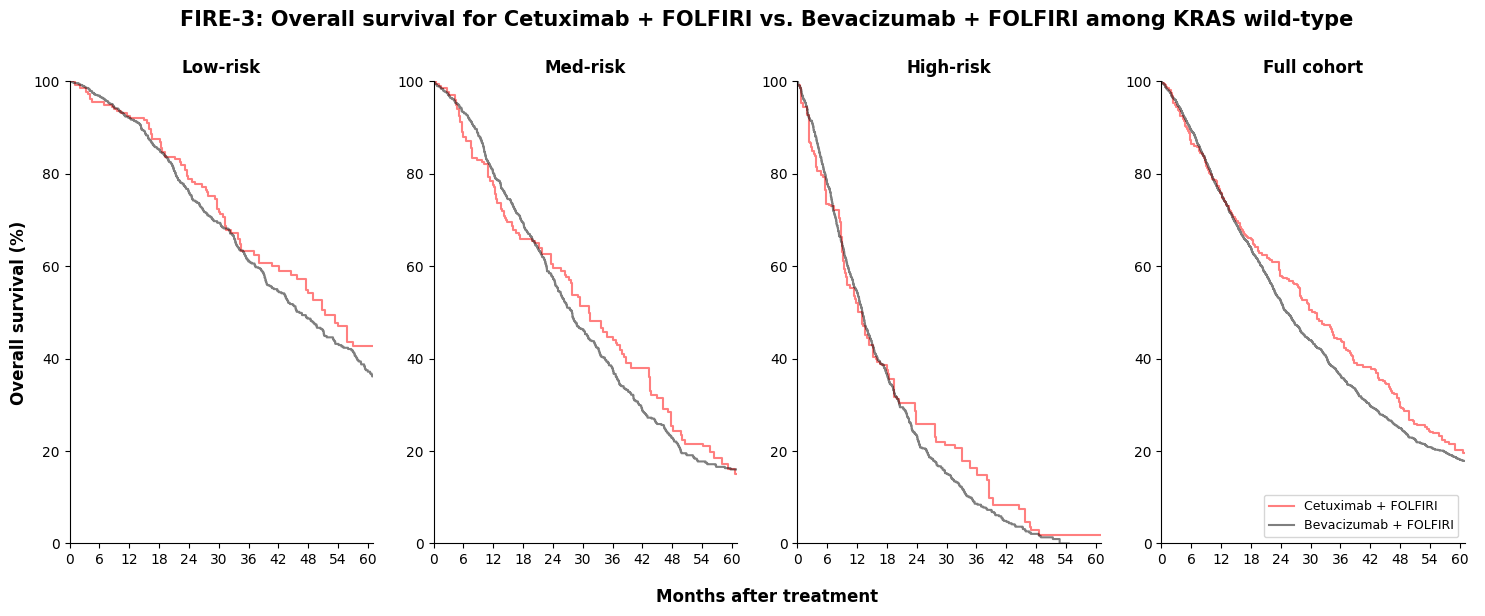

In [107]:
fig = plt.figure(figsize=(18, 6))

# Plot survival curves for low risk group 
plt.subplot(1, 4, 1)

plt.step(kmf_low_cet_f_iptw.timeline, kmf_low_cet_f_iptw.survival_function_.values*100, color = 'red', alpha = 0.5)

plt.step(kmf_low_bev_f_iptw.timeline, kmf_low_bev_f_iptw.survival_function_.values*100, color = 'black', alpha = 0.5)

plt.xticks(np.arange(0, 61, 6))
plt.xlim(0, 61)
plt.ylim(0, 100)

plt.title('Low-risk', weight = 'bold')
plt.ylabel('Overall survival (%)', size = 12, weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Plot survival curves for med risk group. 
plt.subplot(1, 4, 2)

plt.step(kmf_med_cet_f_iptw.timeline, kmf_med_cet_f_iptw.survival_function_.values*100, color = 'red', alpha = 0.5)

plt.step(kmf_med_bev_f_iptw.timeline, kmf_med_bev_f_iptw.survival_function_.values*100, color = 'black', alpha = 0.5)

plt.xticks(np.arange(0, 61, 6))
plt.xlim(0, 61)
plt.ylim(0, 100)

plt.title('Med-risk', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Plot survival curves by treatment for high risk group. 
plt.subplot(1, 4, 3)

plt.step(kmf_high_cet_f_iptw.timeline, kmf_high_cet_f_iptw.survival_function_.values*100, color = 'red', alpha = 0.5)

plt.step(kmf_high_bev_f_iptw.timeline, kmf_high_bev_f_iptw.survival_function_.values*100, color = 'black', alpha = 0.5)

plt.xticks(np.arange(0, 61, 6))
plt.xlim(0, 61)
plt.ylim(0, 100)

plt.title('High-risk', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Plot survival curves by treatment for all risk group. 
plt.subplot(1, 4, 4)

plt.step(kmf_all_cet_f_iptw.timeline, kmf_all_cet_f_iptw.survival_function_.values*100, color = 'red', alpha = 0.5, label = 'Cetuximab + FOLFIRI')

plt.step(kmf_all_bev_f_iptw.timeline, kmf_all_bev_f_iptw.survival_function_.values*100, color = 'black', alpha = 0.5, label = 'Bevacizumab + FOLFIRI')

plt.xticks(np.arange(0, 61, 6))
plt.xlim(0, 61)
plt.ylim(0, 100)

plt.title('Full cohort', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.legend(loc = 'lower right', prop = {'size': 9})

fig.add_subplot(1, 1, 1, frameon = False)
plt.tick_params(labelcolor = 'none', which = 'both', top = False, bottom = False, left = False, right = False)
plt.xlabel('Months after treatment', labelpad = 15, size = 12, weight = 'bold')
plt.title('FIRE-3: Overall survival for Cetuximab + FOLFIRI vs. Bevacizumab + FOLFIRI among KRAS wild-type', pad = 40, size = 15, weight = 'bold')

plt.show()